In [35]:
import numpy as np
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
from sklearn.utils import shuffle
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import time


MNIST data loaded
Five sample data


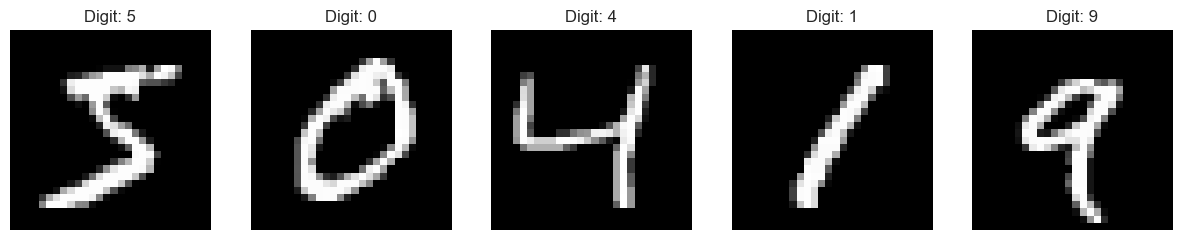

In [12]:
# Loading MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('MNIST data loaded')

# Reshape the data
X_train = x_train.reshape(x_train.shape[0], -1)
X_test = x_test.reshape(x_test.shape[0], -1)

# Normalize
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Display sample images
print('Five sample data')
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f'Digit: {y_train[i]}')
    plt.axis('off')
plt.show()

In [25]:
print(x_train[1].shape)

(28, 28)


In [13]:
# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=192
)

# Normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Validation set shape: {X_val_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Training set shape: (48000, 784)
Validation set shape: (12000, 784)
Test set shape: (10000, 784)


In [14]:
# Feature engineering with HOG
def extract_hog_features(X):
    features = []
    for image in X.reshape(-1, 28, 28):
        fd = hog(image, orientations=9, pixels_per_cell=(8, 8),
                cells_per_block=(2, 2), visualize=False)
        features.append(fd)
    return np.array(features)

HOG feature extraction


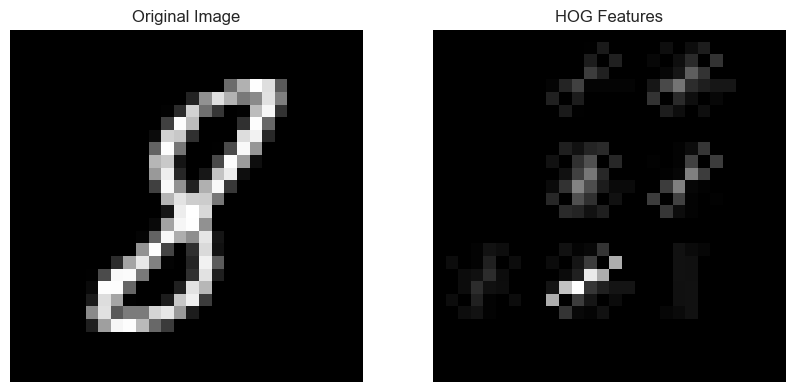

In [15]:
# Extract HOG features
print('HOG feature extraction')
X_train_hog = extract_hog_features(X_train)
X_val_hog = extract_hog_features(X_val)
X_test_hog = extract_hog_features(X_test)

# Visualize HOG features for a sample image
sample_image = X_train[0].reshape(28, 28)
_, hog_image = hog(sample_image, orientations=9, pixels_per_cell=(8, 8),
                  cells_per_block=(2, 2), visualize=True)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(sample_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Features')
plt.axis('off')
plt.show()

In [26]:
# Grid search
# Prep
# Utilize GPU if possible
def get_device():
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print('Apple mps available')
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print('NVIDIA cuda available')
    else:
        device = torch.device("cpu")
        print('default to cpu')
    return device
device = get_device()

class HOGFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        for image in tqdm(X.reshape(-1, 28, 28), desc="Extracting HOG features"):
            fd = hog(image,
                     orientations=self.orientations,
                     pixels_per_cell=self.pixels_per_cell,
                     cells_per_block=self.cells_per_block,
                     visualize=False)
            features.append(fd)
        return np.array(features)


Apple mps available


In [29]:
# Create a pipeline
pipeline = Pipeline([
    ('hog', HOGFeatureExtractor()),
    ('scaler', StandardScaler()),  # Standardize features
    ('svm', LinearSVC(max_iter=10000))
])

# Define parameter grid for grid search
param_grid = {
    'hog__orientations': [8, 9],
    'hog__pixels_per_cell': [(6, 6), (8, 8)],
    'hog__cells_per_block': [(2, 2)],
    'svm__C': [0.1, 1, 10]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

# Combine train and validation sets for grid search
X_combined = np.vstack((X_train, X_val))
y_combined = np.concatenate((y_train, y_val))

# Fit grid search
grid_search.fit(X_combined, y_combined)

# Output the best parameters and estimator
print("Best parameters found:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


Extracting HOG features: 100%|██████████| 20000/20000 [00:01<00:00, 11051.51it/s]


[CV] END hog__cells_per_block=(2, 2), hog__orientations=8, hog__pixels_per_cell=(8, 8), svm__C=0.1; total time=  25.4s


Extracting HOG features:   2%|▏         | 720/40000 [00:00<00:05, 7178.46it/s]s]

[CV] END hog__cells_per_block=(2, 2), hog__orientations=8, hog__pixels_per_cell=(6, 6), svm__C=0.1; total time=  44.9s


Extracting HOG features:  10%|█         | 4162/40000 [00:00<00:04, 8477.73it/s]

[CV] END hog__cells_per_block=(2, 2), hog__orientations=8, hog__pixels_per_cell=(6, 6), svm__C=0.1; total time=  45.4s


Extracting HOG features:  48%|████▊     | 9583/20000 [00:01<00:01, 5922.68it/s]]

[CV] END hog__cells_per_block=(2, 2), hog__orientations=8, hog__pixels_per_cell=(6, 6), svm__C=10; total time=  47.5s


Extracting HOG features:  36%|███▌      | 7232/20000 [00:00<00:00, 14668.51it/s]]

[CV] END hog__cells_per_block=(2, 2), hog__orientations=8, hog__pixels_per_cell=(6, 6), svm__C=1; total time=  48.0s


Extracting HOG features:  46%|████▋     | 18514/40000 [00:01<00:01, 11067.39it/s]

[CV] END hog__cells_per_block=(2, 2), hog__orientations=8, hog__pixels_per_cell=(8, 8), svm__C=0.1; total time=  23.7s


Extracting HOG features:  35%|███▌      | 14115/40000 [00:01<00:03, 8136.56it/s]

[CV] END hog__cells_per_block=(2, 2), hog__orientations=8, hog__pixels_per_cell=(6, 6), svm__C=0.1; total time=  49.5s


Extracting HOG features:  41%|████      | 16428/40000 [00:01<00:02, 9672.04it/s]

[CV] END hog__cells_per_block=(2, 2), hog__orientations=8, hog__pixels_per_cell=(6, 6), svm__C=1; total time=  49.9s


Extracting HOG features:   2%|▏         | 754/40000 [00:00<00:05, 7536.68it/s]s]

[CV] END hog__cells_per_block=(2, 2), hog__orientations=8, hog__pixels_per_cell=(6, 6), svm__C=10; total time=  54.6s


Extracting HOG features:   1%|▏         | 592/40000 [00:00<00:06, 5911.24it/s]]

[CV] END hog__cells_per_block=(2, 2), hog__orientations=8, hog__pixels_per_cell=(6, 6), svm__C=1; total time=  56.0s


Extracting HOG features: 100%|██████████| 20000/20000 [00:03<00:00, 5987.93it/s]


[CV] END hog__cells_per_block=(2, 2), hog__orientations=8, hog__pixels_per_cell=(6, 6), svm__C=10; total time= 1.1min


Extracting HOG features:   0%|          | 0/40000 [00:00<?, ?it/s], 6440.00it/s]

[CV] END hog__cells_per_block=(2, 2), hog__orientations=8, hog__pixels_per_cell=(8, 8), svm__C=10; total time=  21.4s


Extracting HOG features:   0%|          | 0/40000 [00:00<?, ?it/s] 8968.38it/s]s]

[CV] END hog__cells_per_block=(2, 2), hog__orientations=8, hog__pixels_per_cell=(8, 8), svm__C=0.1; total time=  28.3s
[CV] END hog__cells_per_block=(2, 2), hog__orientations=8, hog__pixels_per_cell=(8, 8), svm__C=1; total time=  27.9s


Extracting HOG features:  10%|▉         | 3970/40000 [00:00<00:06, 5958.61it/s]

[CV] END hog__cells_per_block=(2, 2), hog__orientations=8, hog__pixels_per_cell=(8, 8), svm__C=10; total time=  24.1s


Extracting HOG features:   1%|▏         | 573/40000 [00:00<00:06, 5720.57it/s]s]

[CV] END hog__cells_per_block=(2, 2), hog__orientations=8, hog__pixels_per_cell=(8, 8), svm__C=1; total time=  27.3s


Extracting HOG features:  24%|██▎       | 9404/40000 [00:01<00:05, 5423.52it/s]]

[CV] END hog__cells_per_block=(2, 2), hog__orientations=8, hog__pixels_per_cell=(8, 8), svm__C=10; total time=  26.8s


Extracting HOG features:   0%|          | 0/40000 [00:00<?, ?it/s], 6600.23it/s]

[CV] END hog__cells_per_block=(2, 2), hog__orientations=8, hog__pixels_per_cell=(8, 8), svm__C=1; total time=  29.0s


Extracting HOG features:   0%|          | 0/40000 [00:00<?, ?it/s]

[CV] END hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(6, 6), svm__C=0.1; total time=  46.1s


Extracting HOG features:   0%|          | 0/40000 [00:00<?, ?it/s], 8618.03it/s]

[CV] END hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(6, 6), svm__C=0.1; total time=  58.4s


Extracting HOG features:  23%|██▎       | 9142/40000 [00:01<00:03, 9435.63it/s]

[CV] END hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(8, 8), svm__C=0.1; total time=  38.6s


Extracting HOG features:   0%|          | 0/40000 [00:00<?, ?it/s], 10411.31it/s]

[CV] END hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(6, 6), svm__C=0.1; total time=  51.5s


Extracting HOG features:  29%|██▉       | 5756/20000 [00:00<00:02, 6252.23it/s]]

[CV] END hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(8, 8), svm__C=0.1; total time=  34.9s


Extracting HOG features:  40%|████      | 16155/40000 [00:01<00:02, 8096.64it/s]

[CV] END hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(6, 6), svm__C=1; total time= 1.1min


Extracting HOG features:  45%|████▌     | 18036/40000 [00:01<00:02, 8704.13it/s]/Users/ygao/anaconda3/envs/B1b24advMLproject/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Extracting HOG features:  61%|██████    | 24240/40000 [00:02<00:01, 9918.54it/s] 

[CV] END hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(6, 6), svm__C=1; total time= 1.1min


Extracting HOG features:  65%|██████▌   | 26196/40000 [00:02<00:01, 9805.76it/s]

[CV] END hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(8, 8), svm__C=1; total time=  26.3s


Extracting HOG features: 100%|██████████| 20000/20000 [00:01<00:00, 10185.64it/s]


[CV] END hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(6, 6), svm__C=1; total time= 1.6min


Extracting HOG features: 100%|██████████| 20000/20000 [00:01<00:00, 10325.85it/s]


[CV] END hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(6, 6), svm__C=10; total time= 1.9min


Extracting HOG features: 100%|██████████| 20000/20000 [00:01<00:00, 10453.97it/s]


[CV] END hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(6, 6), svm__C=10; total time= 2.2min


Extracting HOG features: 100%|██████████| 60000/60000 [00:05<00:00, 10252.84it/s]


Best parameters found: {'hog__cells_per_block': (2, 2), 'hog__orientations': 9, 'hog__pixels_per_cell': (6, 6), 'svm__C': 0.1}


In [31]:
# Best parameters
def best_extract_hog_features(X, orientations=9, pixels_per_cell=(6, 6), cells_per_block=(2, 2)):
    features = []
    for image in X.reshape(-1, 28, 28):
        fd = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                 cells_per_block=cells_per_block, visualize=False)
        features.append(fd)
    return np.array(features)
print('Extracting HOG')
X_train_hog_best = extract_hog_features(X_train)
X_val_hog_best = extract_hog_features(X_val)
X_test_hog_best = extract_hog_features(X_test)
print('HOG feature extraction completed.')

Extracting HOG
HOG feature extraction completed.


In [32]:
# Standardize
scaler = StandardScaler()
X_train_hog_best = scaler.fit_transform(X_train_hog_best)
X_val_hog_best = scaler.transform(X_val_hog_best)
X_test_hog_best = scaler.transform(X_test_hog_best)

In [33]:
# Initialize the SVM with the best parameters
svm = SVC(C=0.1, kernel='linear', random_state=192)

# Fit the model on the combined training and validation set
X_combined = np.vstack((X_train_hog_best, X_val_hog_best))
y_combined = np.concatenate((y_train, y_val))
svm.fit(X_combined, y_combined)
print('Model training completed.')

Model training completed.


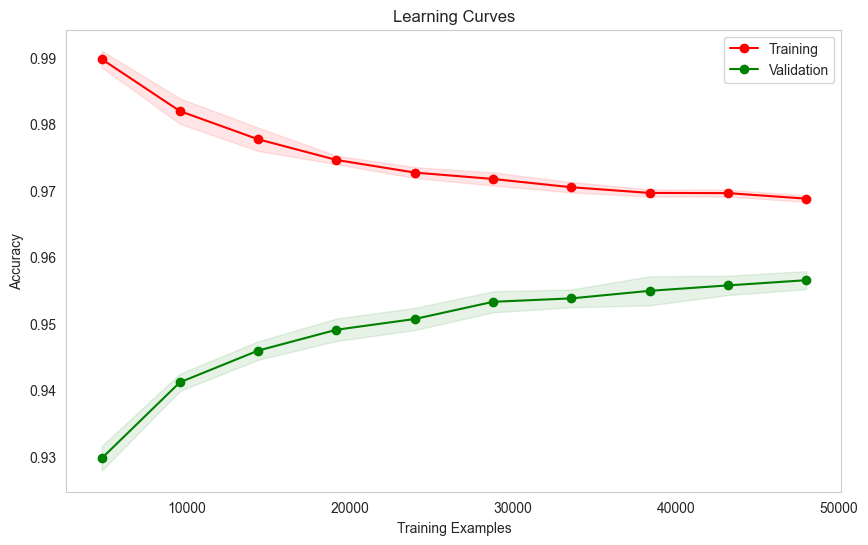

In [39]:
def plot_learning_curves(estimator, X, y, cv, train_sizes):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy', n_jobs=-1
    )

    # Calculate mean and standard deviation for training and validation scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training')
    plt.plot(train_sizes, val_mean, 'o-', color='g', label='Validation')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')
    plt.title('Learning Curves')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Plot learning curves using 5-fold cross-validation
plot_learning_curves(svm, X_combined, y_combined, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.94      0.96      0.95      1032
           3       0.94      0.96      0.95      1010
           4       0.96      0.95      0.96       982
           5       0.97      0.95      0.96       892
           6       0.97      0.98      0.97       958
           7       0.96      0.94      0.95      1028
           8       0.96      0.94      0.95       974
           9       0.95      0.94      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



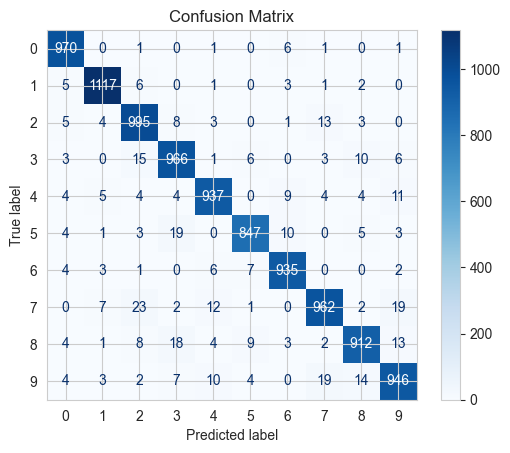

In [37]:
# Predict on the test set
y_pred = svm.predict(X_test_hog_best)

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()